# Assignment 6

### Use the Plant Seedlings Dataset to attempt the following questions. Find the dataset here

1) Write your own functions to load the data, normalize the data, OHE for categories.

2) If you find unbalanced data, augment the classes accordingly.

3) Use pre-trained VGG16, ResNet50 and InceptionV3 networks to extract bottleneck features and build a model on top of each of them to evaluate and compare the model performances. 

(Model performances include classification report, confusion matrices, plots of Loss Vs Epochs)

4) Write 2 separate scripts: 

    a. To train the network and save the model with highest validation accuracy. Save model - model.save("model.h5")
    b. Load the model and predict on the test data. Load Model - model = load_model("model.h5")

# **Neccesary Imports**

> This section just imports all the neccesary packages

In [2]:
import numpy as np
import itertools
import pandas as pd
import os
import math
import random
import cv2
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from imgaug import augmenters as iaa
from tqdm.notebook import tqdm

In [3]:
# Set some global variables
train_dir = "../input/plant-seedlings-classification/train/"
test_dir = "../input/plant-seedlings-classification/test/"
save_dir = "/kaggle/working/plant-seedlings-classification/train"
target_size = (224, 224)

# **1. Visualising the Dataset**

> we will look at the **class distributions.**


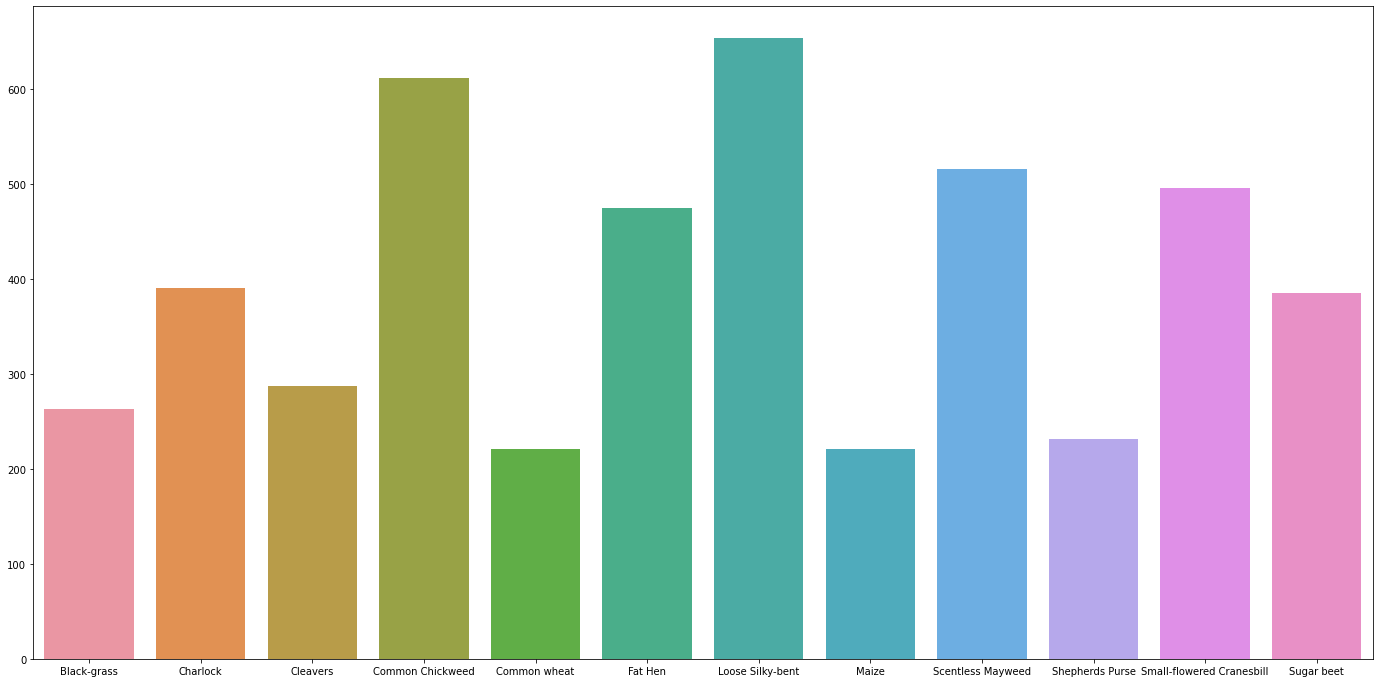

In [4]:
# Get names of all the categories 
categories = [category for category in sorted(os.listdir(train_dir))]

# Get the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(train_dir, category))) for category in categories]

# Plot to see the distribution
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

## **Conclusions**

---


* The **lowest number of images (for a class) is 221** and the **highest number of images (for a class) is 654**

---

# **2. Defining the DataLoader and Utilities Classes**

In [5]:
class DataLoader():
    """
    Args:
    train_dir -- points to the training directory
    test_dir -- points to the test directory
    save_dir -- points to the path where augmented data should be stored
    segmentation -- flag to indicate whether to apply segmentation during preprocessing or not
    target_size -- the size to which each image in the dataset should be resized
    
    Returns:
    An instance of itself
    """
    
    def __init__(self, **kwargs):
        
        self.train_dir = kwargs.get('train_dir')
        self.test_dir = kwargs.get('test_dir')
        self.save_dir = kwargs.get('save_dir')
        self.segmentation = kwargs.get('segmentation')
        self.target_size = kwargs.get('target_size')
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        self.data_og = [self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path)) for category in categories for img_path in os.listdir(os.path.join(self.train_dir, category))]
        if self.segmentation:
            self.data_seg = [self.segmentation_pipeline(self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path))) for category in categories for img_path in os.listdir(os.path.join(self.train_dir, category))]
            
        try:
            assert self.train_dir
            assert self.test_dir
            assert self.save_dir
        except (AssertionError, NameError):
            sys.exit("Call to this should class must have at least 1. train_dir,  2. test_dir, 3. save_dir")
        
        
    # Helper Function 1
    # Create a binary mask for a given HSV range
    def create_mask_for_plant(self, image):
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_hsv = np.array([25, 50, 50])
        upper_hsv = np.array([95, 255, 255])
        mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        return mask

    # Helper Function 2
    # Use the binary mask to segment the image
    def segment_plant(self, image):
        mask = self.create_mask_for_plant(image)
        output = cv2.bitwise_and(image, image, mask = mask)
        return output

    # Helper Function 3
    # Sharpen the segmented image for contrast
    def sharpen_image(self, image):
        image_sharp = cv2.bilateralFilter(image, 11, 11, 11) 
        return image_sharp

    # Helper Function 4 
    # Augment passed images
    def augment_images(self, class_images):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(rotate=(-45, 45)),
            iaa.TranslateX(percent=(-0.1, 0.1)),
            iaa.TranslateY(percent=(-0.1, 0.1))
        ], random_order=True)

        images_aug = seq(images = class_images)
        return images_aug

    # Helper Function 5
    # Randomly sample images from a set of passed images
    def random_unique_sampling(self, class_images, remainder):
        random_unique_indices = random.sample(range(0, len(class_images)), remainder)
        random_unique_images = [class_images[idx] for idx in random_unique_indices]
        return random_unique_images
        

    def augmentation_pipeline(self, class_images, number_of_images):
        """Accepts a batch of images (of a single class) and returns a required number of augmented images"""

        if number_of_images == 0:
                return []

        elif number_of_images >= len(class_images):
            batches = math.floor(number_of_images / len(class_images))
            remainder = number_of_images % len(class_images)
            remainder_images = self.random_unique_sampling(class_images, remainder)
            class_images = class_images * batches
            class_images.extend(remainder_images)
            images_aug = self.augment_images(class_images)
            return images_aug

        else:
            assert number_of_images < len(class_images)
            class_images = self.random_unique_sampling(class_images, number_of_images)
            images_aug = self.augment_images(class_images)
            return images_aug
        
    def preprocessing_pipeline(self, path):
        """Accepts a path and returns a processed image involving reading and resizing"""
        image = cv2.resize(cv2.imread(path), self.target_size, interpolation = cv2.INTER_NEAREST)
        return image


    def segmentation_pipeline(self, image):
        """Accepts an image and returns a HSV segmented version of the image"""
        image_segmented = self.segment_plant(image)
        image_sharpen = self.sharpen_image(image_segmented)
        return image_sharpen
    
    
    def balance_dataset(self):
        """Create augmented data to balance classes from the passed training data path"""
        
        # Make a directory for augmented dataset
        os.makedirs(self.save_dir, exist_ok=True)
        
        # Get categories
        categories = [category for category in sorted(os.listdir(self.train_dir))]

        # Get the maximum amount of images that exists in a class
        max_in_class = max([len(os.listdir(os.path.join(self.train_dir, category))) for category in categories])

        # Find out the number of images that exist in each class
        images_per_category = {category : len(os.listdir(os.path.join(self.train_dir, category))) for category in categories}

        # Find out the augmentations required for each class
        required_augmentations = dict(zip(categories,  [max_in_class - num_in_class for num_in_class in list(images_per_category.values())]))

        # Augment each unbalanced class and save the new dataset to disk
        # We preferring saving the data to disk
        # Because we prefer to not hold large numpy arrays in the RAM
        # This allows for large models to be loaded and trained on
        # We use for loops here instead of list comprehensions for readiblity
        for category in tqdm(categories):
            try:
                os.mkdir(os.path.join(self.save_dir, category))
            except FileExistsError:
                pass
            class_images = list()

            # Preprocessing and Augmentation
            for img_path in sorted(os.listdir(os.path.join(self.train_dir, category))):
                image = self.preprocessing_pipeline(os.path.join(self.train_dir, category, img_path))
                if self.segmentation == True:
                    image = self.segmentation_pipeline(image)
                class_images.append(image)
            augmented_images = self.augmentation_pipeline(class_images, required_augmentations[category])
            class_images.extend(augmented_images)

            # Writing the augmented data to disk
            for image_number, class_image in enumerate(class_images):
                cv2.imwrite(os.path.join(self.save_dir, category, "{}.png".format(image_number + 1)), class_image)
        
    def load_for_train(self, model):
        
        if model == "resnet50":
            datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2, validation_split=0.15)
            target_size = (224, 224)
        elif model == "inception_v3":
            datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input,samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2, validation_split=0.15)
            target_size = (299, 299)
        elif model == 'vgg16':
            datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input,samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2, validation_split=0.15)
            target_size = (224, 224)
        else:
            sys.exit('Fatal Error: Invalid Model Requested.')


        train_generator = datagen.flow_from_directory(
                directory= os.path.join(self.save_dir),
                target_size= target_size,
                class_mode = "categorical",
                batch_size=32,
                shuffle=True,
                subset='training'
            )
        
        val_generator = datagen.flow_from_directory(
                directory= os.path.join(self.save_dir),
                target_size= target_size,
                class_mode = 'categorical',
                batch_size=32,
                shuffle=False,
                subset='validation'
            )

        return train_generator, val_generator
        
    def load_for_viz(self, model):
        
        if model == "resnet50":
            datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        elif model == "inception_v3":
            datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
            target_size = (299, 299)
        elif model == 'vgg16':
            datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)
            target_size = (224, 224)
        else:
            sys.exit('Fatal Error: Invalid Model Requested.')

        generator = datagen.flow_from_directory(
        directory= os.path.join(self.save_dir),
        target_size= target_size,
        batch_size=1,
        class_mode=None,
        shuffle=False
        )
        
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        max_in_class = max([len(os.listdir(os.path.join(self.train_dir, category))) for category in categories])
        categories_rep = list(itertools.chain.from_iterable(itertools.repeat(x, max_in_class) for x in categories))
        data_df = pd.DataFrame(categories_rep, columns = ["categories"])
        
        return generator, data_df
    
    def show_sample_images(self):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        random_indices = random.sample(range(0, len(self.data_og)), 4)
        
        # Plot some sample images from the dataset
        _, axs = plt.subplots(1, 4, figsize=(20, 20))
        for i in range(4):
            axs[i].imshow(self.data_og[random_indices[i]])
        
        # Plot segmented images if segmentation is True
        if self.segmentation:
            _, axs = plt.subplots(1, 4, figsize=(20, 20))
            for i in range(4):
                axs[i].imshow(self.data_seg[random_indices[i]])
            

In [6]:
class Utilities:
    """
    Boilerplate code that can be re-used multiple times to plot training graphs, visualization plots, training summary.
    
    Args:
    train_dir -- points to the training directory
    
    Returns:
    An instance of itself
    """
    
    def __init__(self, train_dir, save_dir):
        self.train_dir = train_dir
        self.save_dir = save_dir
        
                
    def summarize_model(self, history_model, model, val_generator):
        categories = [category for category in sorted(os.listdir(self.train_dir))]
        self.plot_curves(history_model)
        self.plot_classification_metrics(categories, model, val_generator)


    def plot_curves(self, history):
        plt.style.use('seaborn')
        '''
        Args:
        history(History callback): which has a history attribute containing the lists of successive losses and other metrics
        NUM_EPOCHS(int): Number of epochs
        '''
        plt.style.use('seaborn')
        NUM_EPOCHS = len(history.history['loss'])
        plt.style.use("ggplot")
        plt.figure(figsize=(16,10))
        plt.plot(np.arange(0, NUM_EPOCHS), history.history['loss'], label='train_loss')
        plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_loss'], label='val_loss')
        plt.plot(np.arange(0, NUM_EPOCHS), history.history['accuracy'], label='train_acc')
        plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_accuracy'], label='val_acc')
        plt.title("Training Loss and Accuracy on Dataset")
        plt.xlabel("Epochs")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        
    def plot_classification_metrics(self, categories, model, val_generator):

        predictiions = model.predict_generator(val_generator, 48)
        y_pred = np.argmax(predictiions, axis=1)
        cf_matrix = confusion_matrix(val_generator.classes, y_pred)
        print('Classification Report')
        print(classification_report(val_generator.classes, y_pred, target_names=categories))
        plt.figure(figsize=(20,20))
        sns.heatmap(cf_matrix, annot=True, xticklabels=categories, yticklabels=categories, cmap='Blues')

In [6]:
# Instantiate objects of both the classes
# We will then use the methods of these two classes to handle various tasks

# Initialize DataLoader
dataloader = DataLoader(train_dir = train_dir, test_dir = test_dir, save_dir = save_dir, target_size = target_size, segmentation = False)



In [7]:
# Initialize Utilities
utils = Utilities(train_dir, save_dir)

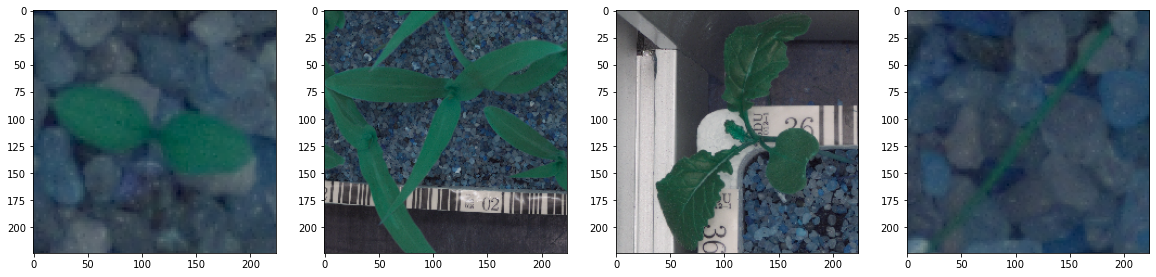

In [8]:
# We can also check out some images of the dataset we have generated
dataloader.show_sample_images()

# 3. Balancing the Dataset using DataLoader

> This section deals with balancing the dataset using data augmentation.

---

* The goal is to balance the dataset such that each class has as many images as any. 

* This means, we will augment each class to match 654 images of the maximum class (Loose-silky Bent)

* This can be handled by calling the `balance_dataset()` method of `DataLoader` 

---


In [9]:
# Balance the dataset
dataloader.balance_dataset()

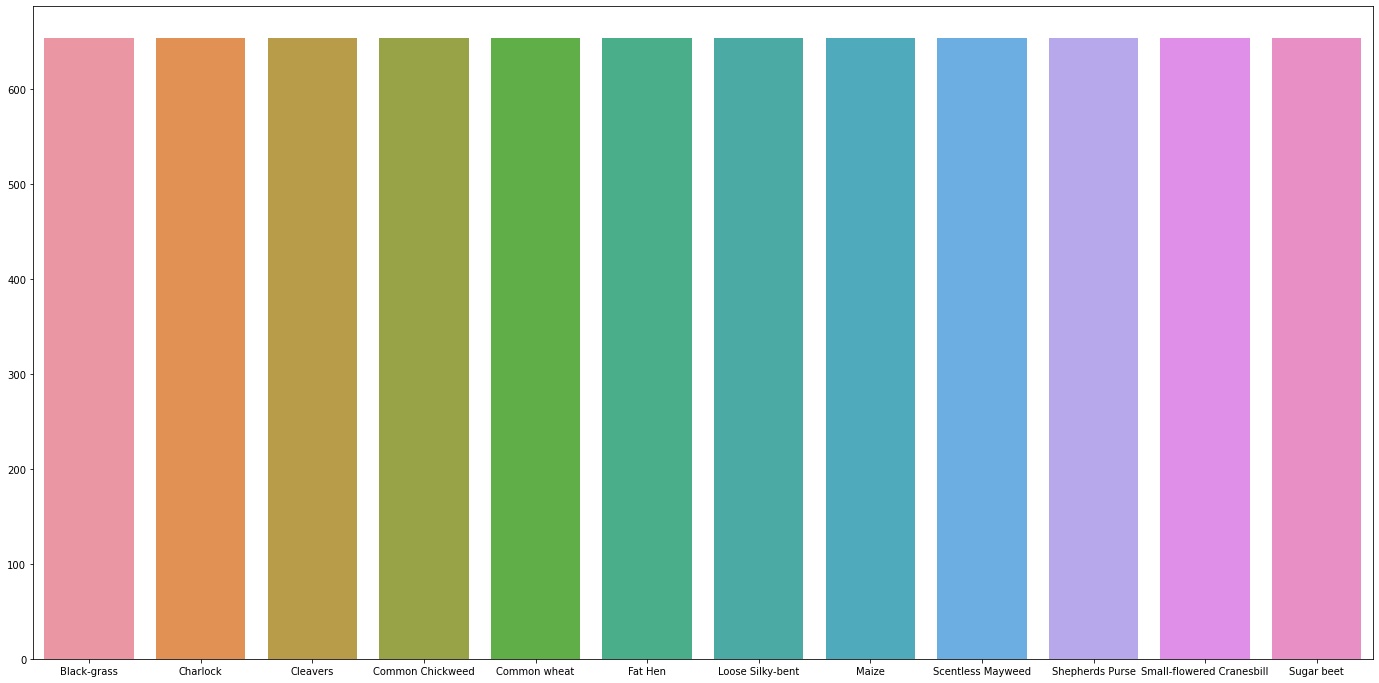

In [10]:
# We can confirm that the dataset was balanced

# Get names of all the categories 
categories = [category for category in sorted(os.listdir(save_dir))]

# Get the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(save_dir, category))) for category in categories]

# Plot to see the distribution
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

## Conclusion

> We can verify that the dataset is now balanced!

---

# **4. Training with Pre-Trained Models (without segmentation)**


We will train the following models to see which gives the best validation and test accuracies
* 
* Inception v3
* VGG16
* ResNet50


## **1. InceptionV3**

In [11]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "inception_v3")

# Define callbacks
model_save_path = '/kaggle/working/model_inceptionv3.h5'
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model_inceptionv3.h5', monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


In [12]:
# Configure model for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:152]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_inception_v3 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])



87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/32
196/196 [==============================] - 172s 876ms/step - loss: 2.2035 - accuracy: 0.2534 - val_loss: 1.4785 - val_accuracy: 0.5918 - lr: 1.0000e-05
Epoch 2/32
196/196 [==============================] - 170s 865ms/step - loss: 1.1725 - accuracy: 0.6531 - val_loss: 0.7267 - val_accuracy: 0.7925 - lr: 1.0000e-05
Epoch 3/32
196/196 [==============================] - 169s 860ms/step - loss: 0.6721 - accuracy: 0.8043 - val_loss: 0.4659 - val_accuracy: 0.8546 - lr: 1.0000e-05
Epoch 4/32
196/196 [==============================] - 169s 862ms/step - loss: 0.4555 - accuracy: 0.8633 - val_loss: 0.3297 - val_accuracy: 0.8988 - lr: 1.0000e-05
Epoch 5/32
196/196 [==============================] - 168s 859ms/step - loss: 0.3375 - accuracy: 0.8967 - val_loss: 0.2928 - val_accuracy: 0.8980 - lr: 1.0000e-05
Epoch 6/32
196/196 [==============================] - 170s 868ms/step - loss: 0.2772 - accuracy: 0.9150 - val_loss: 0.24

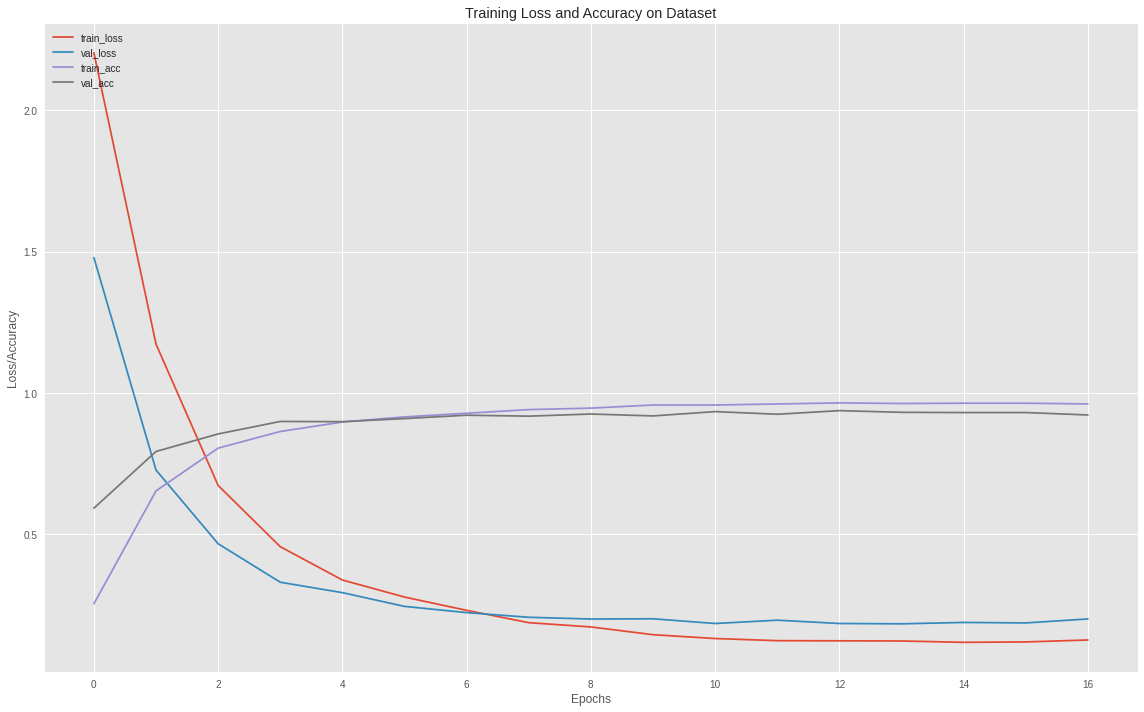

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.88      0.52      0.65        98
                 Charlock       1.00      0.98      0.99        98
                 Cleavers       0.99      0.98      0.98        98
         Common Chickweed       0.96      1.00      0.98        98
             Common wheat       0.98      0.95      0.96        98
                  Fat Hen       0.96      0.98      0.97        98
         Loose Silky-bent       0.66      0.95      0.78        98
                    Maize       0.99      0.98      0.98        98
        Scentless Mayweed       0.91      0.96      0.94        98
          Shepherds Purse       0.98      0.91      0.94        98
Small-flowered Cranesbill       0.99      1.00      0.99        98
               Sugar beet       0.98      0.98      0.98        98

                 accuracy                           0.93      1176
                macro avg       0.94  

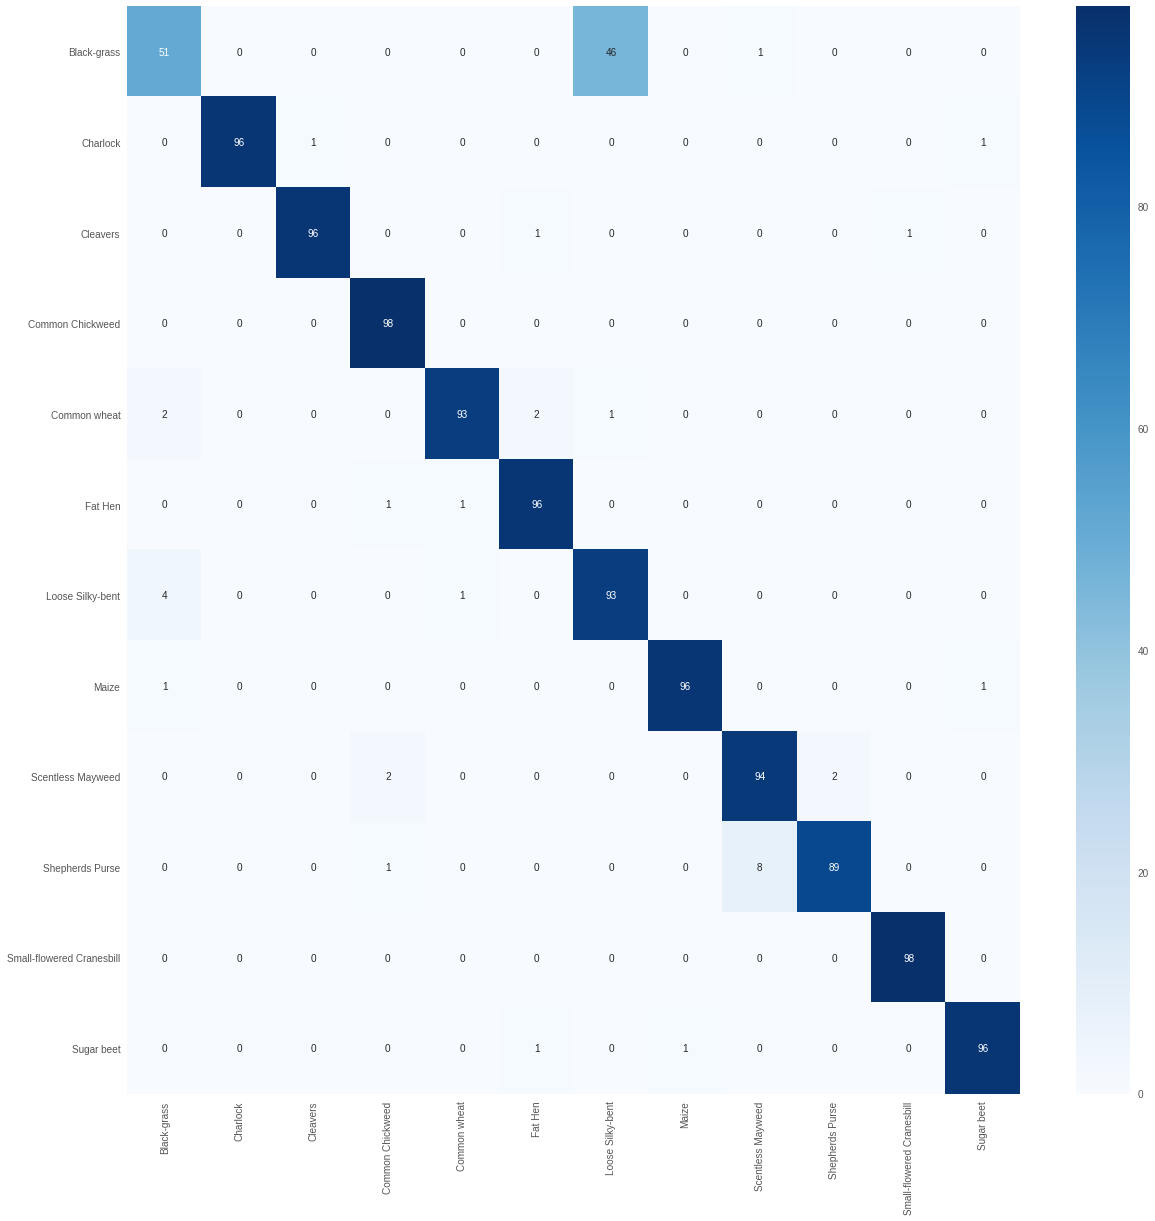

In [13]:
# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_inception_v3, model, val_generator)

## **2. VGG16**

In [14]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "vgg16")

# Define callbacks
model_save_path = '/kaggle/working/model_vgg16.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


In [15]:
# Configure model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:-11]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_vgg16 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])



58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/32
196/196 [==============================] - 103s 527ms/step - loss: 2.5862 - accuracy: 0.1622 - val_loss: 2.2195 - val_accuracy: 0.2440 - lr: 1.0000e-05
Epoch 2/32
196/196 [==============================] - 106s 539ms/step - loss: 1.9581 - accuracy: 0.3312 - val_loss: 1.3339 - val_accuracy: 0.5961 - lr: 1.0000e-05
Epoch 3/32
196/196 [==============================] - 104s 529ms/step - loss: 1.1167 - accuracy: 0.6354 - val_loss: 0.5869 - val_accuracy: 0.8019 - lr: 1.0000e-05
Epoch 4/32
196/196 [==============================] - 103s 525ms/step - loss: 0.6541 - accuracy: 0.7847 - val_loss: 0.4112 - val_accuracy: 0.8546 - lr: 1.0000e-05
Epoch 5/32
196/196 [==============================] - 102s 520ms/step - loss: 0.4862 - accuracy: 0.8389 - val_loss: 0.3827 - val_accuracy: 0.8554 - lr: 1.0000e-05
Epoch 6/32
196/196 [==============================] - 103s 525ms/step - loss: 0.3622 - accuracy: 0.8779 - val_loss: 0.29

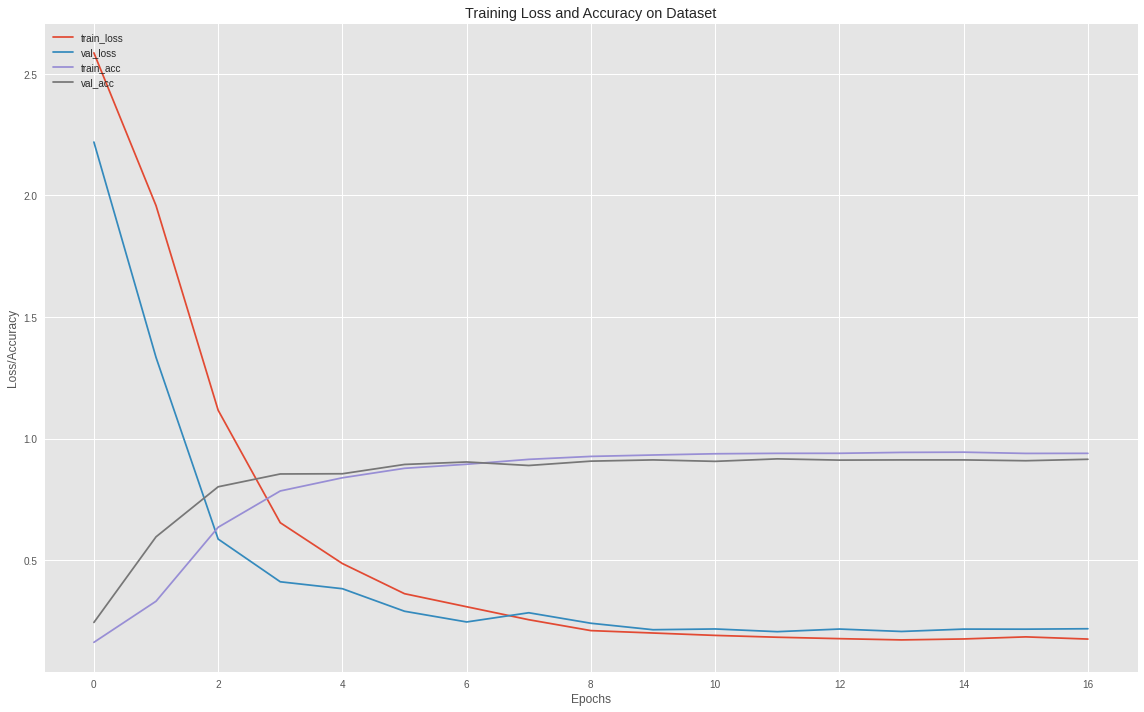

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.85      0.46      0.60        98
                 Charlock       1.00      0.98      0.99        98
                 Cleavers       1.00      0.98      0.99        98
         Common Chickweed       0.91      0.98      0.95        98
             Common wheat       0.96      0.95      0.95        98
                  Fat Hen       0.96      0.96      0.96        98
         Loose Silky-bent       0.63      0.95      0.76        98
                    Maize       0.99      0.99      0.99        98
        Scentless Mayweed       0.85      0.93      0.89        98
          Shepherds Purse       0.92      0.74      0.82        98
Small-flowered Cranesbill       0.98      0.99      0.98        98
               Sugar beet       0.95      0.97      0.96        98

                 accuracy                           0.91      1176
                macro avg       0.92  

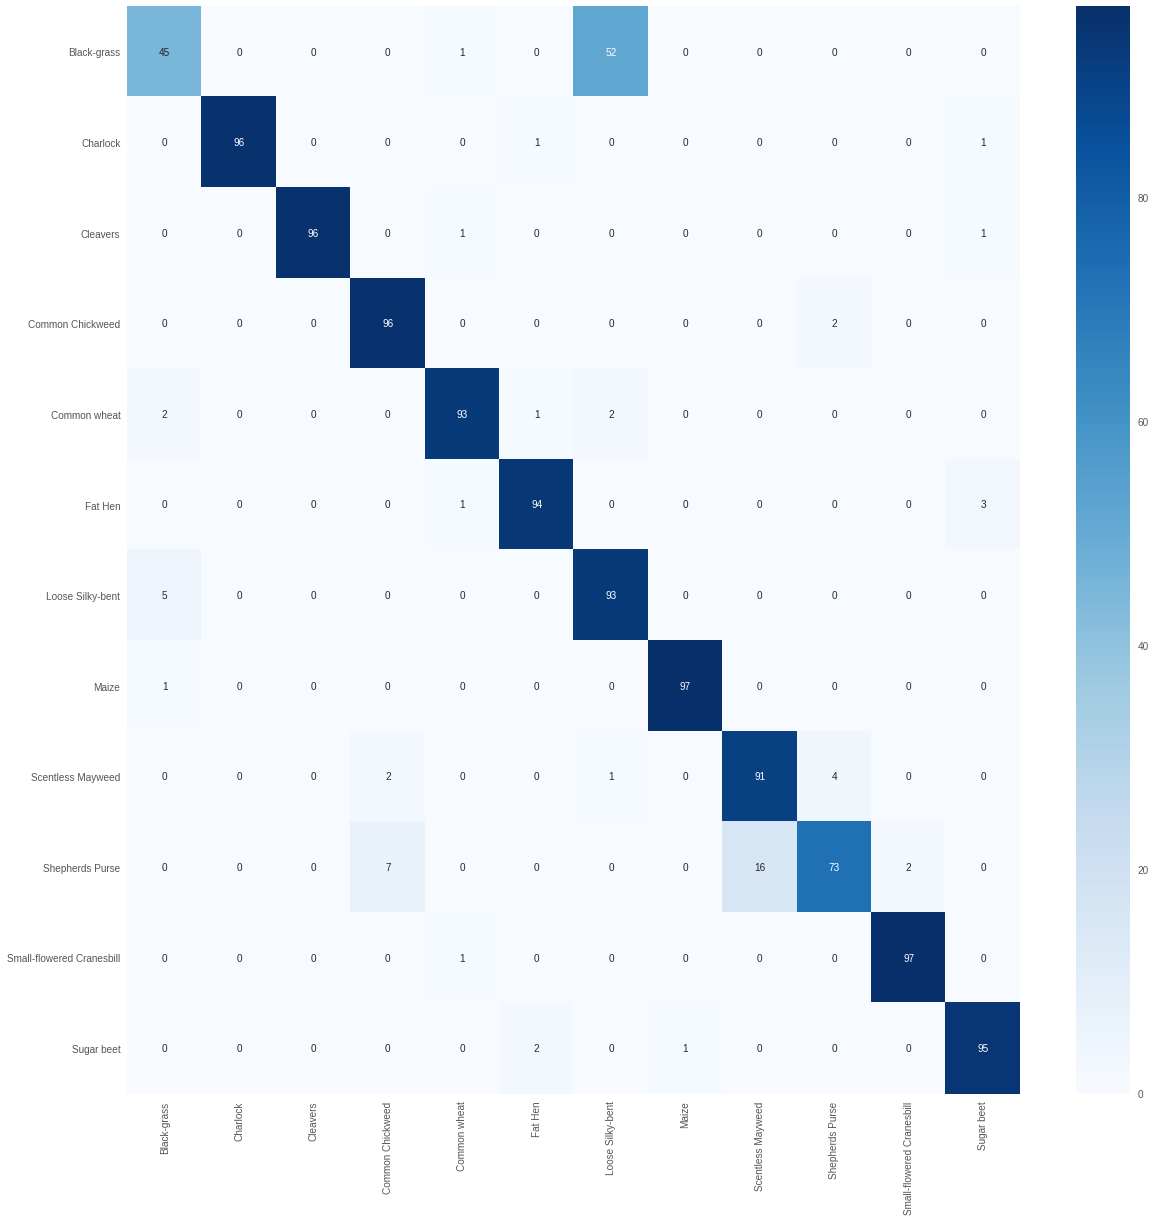

In [16]:
# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_vgg16, model, val_generator)

## **3. ResNet50**

In [17]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "resnet50")

# Define callbacks
model_save_path = '/kaggle/working/model_resent50.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


In [18]:
# Configure model for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:81]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_resent50 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])



94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/32
196/196 [==============================] - 103s 528ms/step - loss: 2.2320 - accuracy: 0.2813 - val_loss: 1.1118 - val_accuracy: 0.6105 - lr: 1.0000e-05
Epoch 2/32
196/196 [==============================] - 103s 526ms/step - loss: 0.9763 - accuracy: 0.6913 - val_loss: 0.5415 - val_accuracy: 0.8180 - lr: 1.0000e-05
Epoch 3/32
196/196 [==============================] - 103s 526ms/step - loss: 0.5283 - accuracy: 0.8347 - val_loss: 0.3562 - val_accuracy: 0.8724 - lr: 1.0000e-05
Epoch 4/32
196/196 [==============================] - 102s 520ms/step - loss: 0.3666 - accuracy: 0.8833 - val_loss: 0.2853 - val_accuracy: 0.8988 - lr: 1.0000e-05
Epoch 5/32
196/196 [==============================] - 102s 521ms/step - loss: 0.2780 - accuracy: 0.9085 - val_loss: 0.2579 - val_accuracy: 0.9073 - lr: 1.0000e-05
Epoch 6/32
196/196 [==============================] - 103s 524ms/step - loss: 0.2323 - accuracy: 0.9242 - val_loss: 0.22

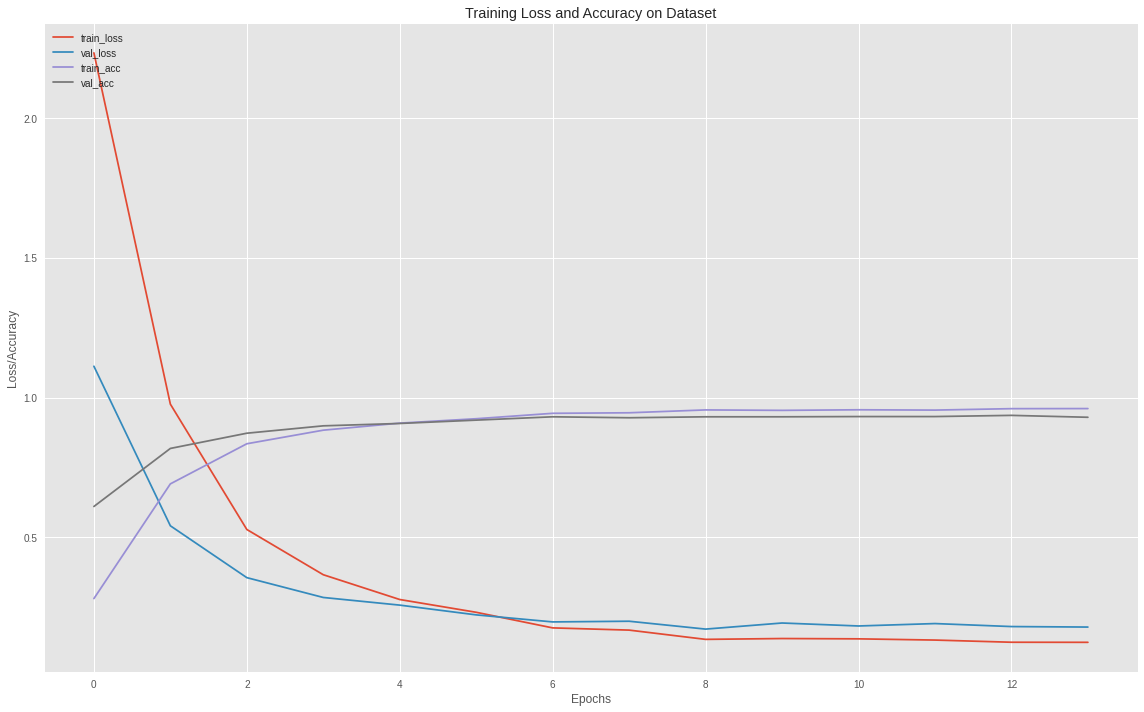

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.85      0.48      0.61        98
                 Charlock       1.00      0.99      0.99        98
                 Cleavers       1.00      0.98      0.99        98
         Common Chickweed       0.95      0.99      0.97        98
             Common wheat       0.99      0.93      0.96        98
                  Fat Hen       0.94      0.96      0.95        98
         Loose Silky-bent       0.64      0.96      0.76        98
                    Maize       1.00      0.98      0.99        98
        Scentless Mayweed       0.92      0.96      0.94        98
          Shepherds Purse       0.98      0.93      0.95        98
Small-flowered Cranesbill       1.00      0.98      0.99        98
               Sugar beet       0.96      0.97      0.96        98

                 accuracy                           0.93      1176
                macro avg       0.94  

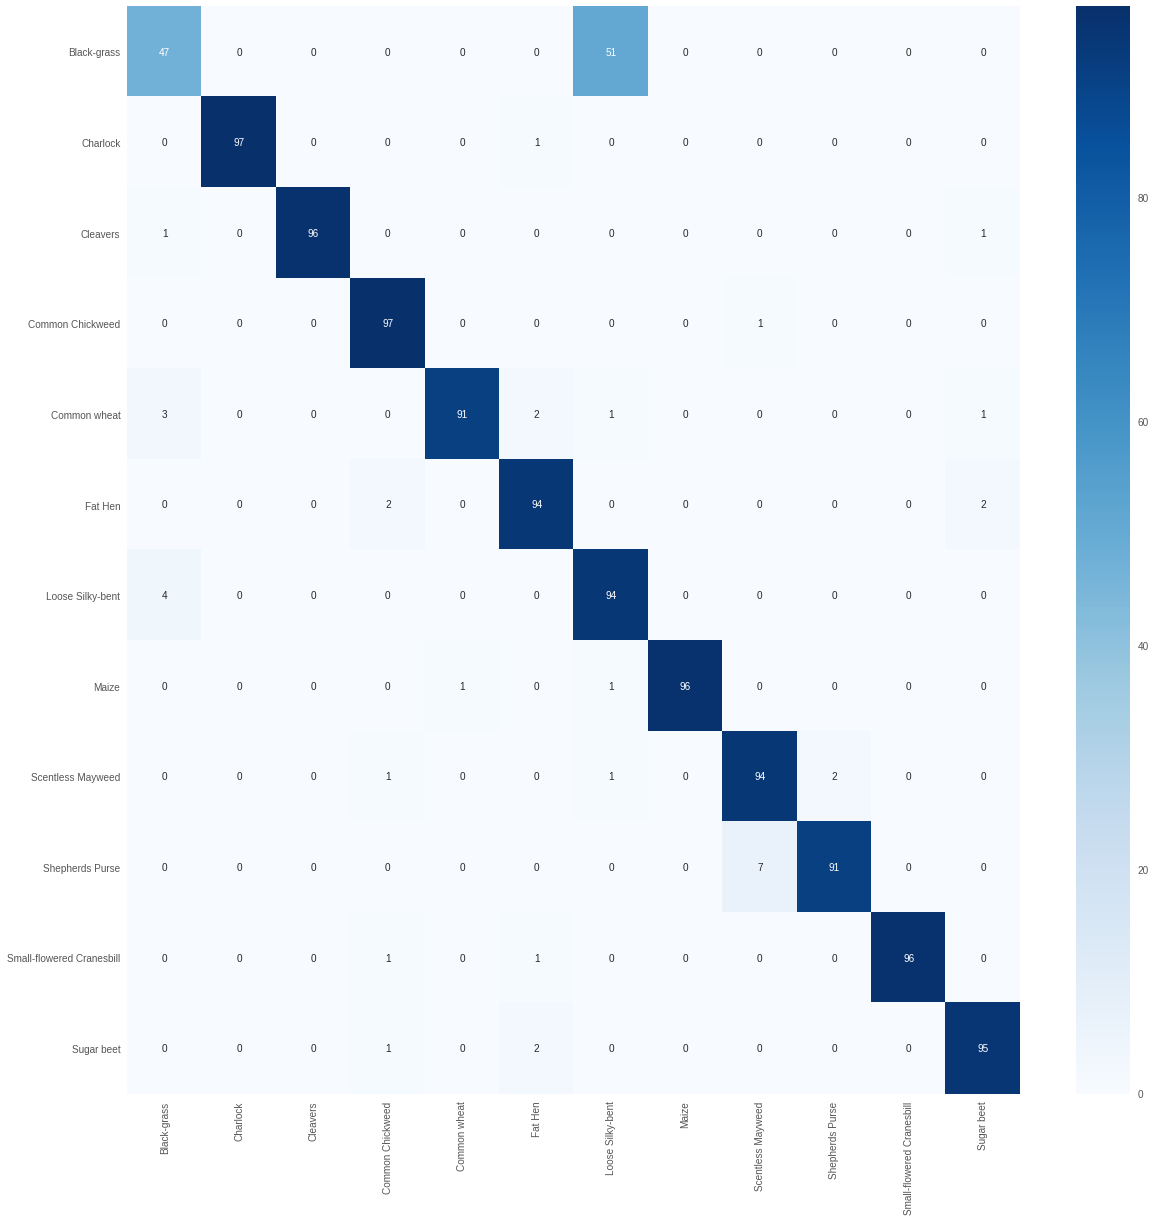

In [19]:
# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_resent50, model, val_generator)

# Segmentation
---

* In this section we would use segmentation as a preprocessing step for our images
* The goal is to extract the the seedling as ROI(region of interest) eliminating the background.

---


In [7]:
# Instantiate objects of both the classes
# We will then use the methods of these two classes to handle various tasks

# Initialize DataLoader
dataloader = DataLoader(train_dir = train_dir, test_dir = test_dir, save_dir = save_dir, target_size = target_size, segmentation = True)



In [8]:
# Initialize Utilities
utils = Utilities(train_dir, save_dir)

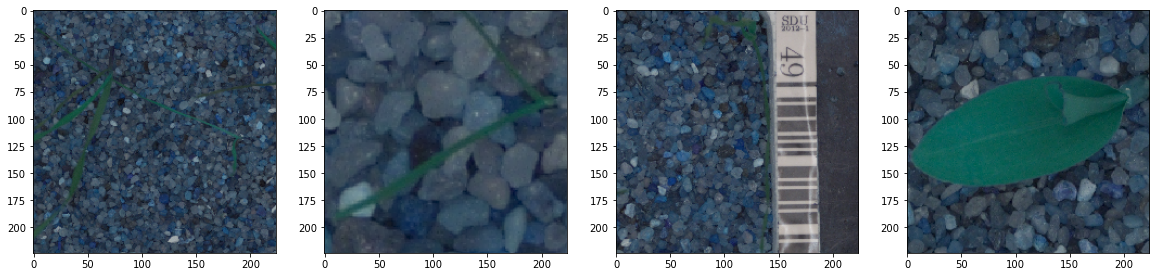

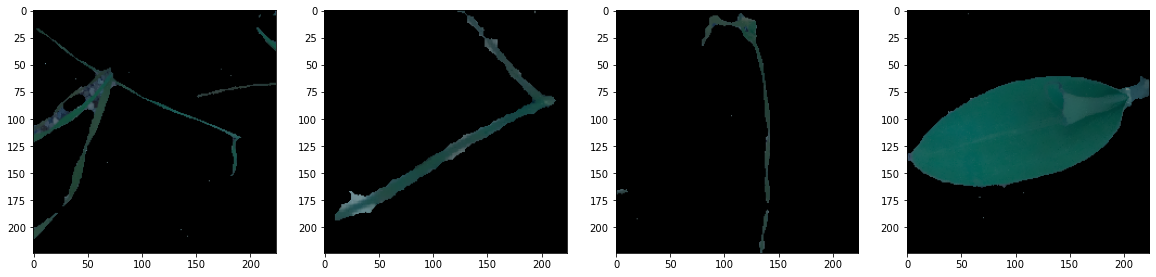

In [9]:
# We can also check out some images of the dataset we have generated
dataloader.show_sample_images()

# 3. Balancing the Dataset using DataLoader

> This section deals with balancing the dataset using data augmentation.

---

* The goal is to balance the dataset such that each class has as many images as any. 

* This means, we will augment each class to match 654 images of the maximum class (Loose-silky Bent)

* This can be handled by calling the `balance_dataset()` method of `DataLoader` 

---


In [10]:
# Balance the dataset
dataloader.balance_dataset()

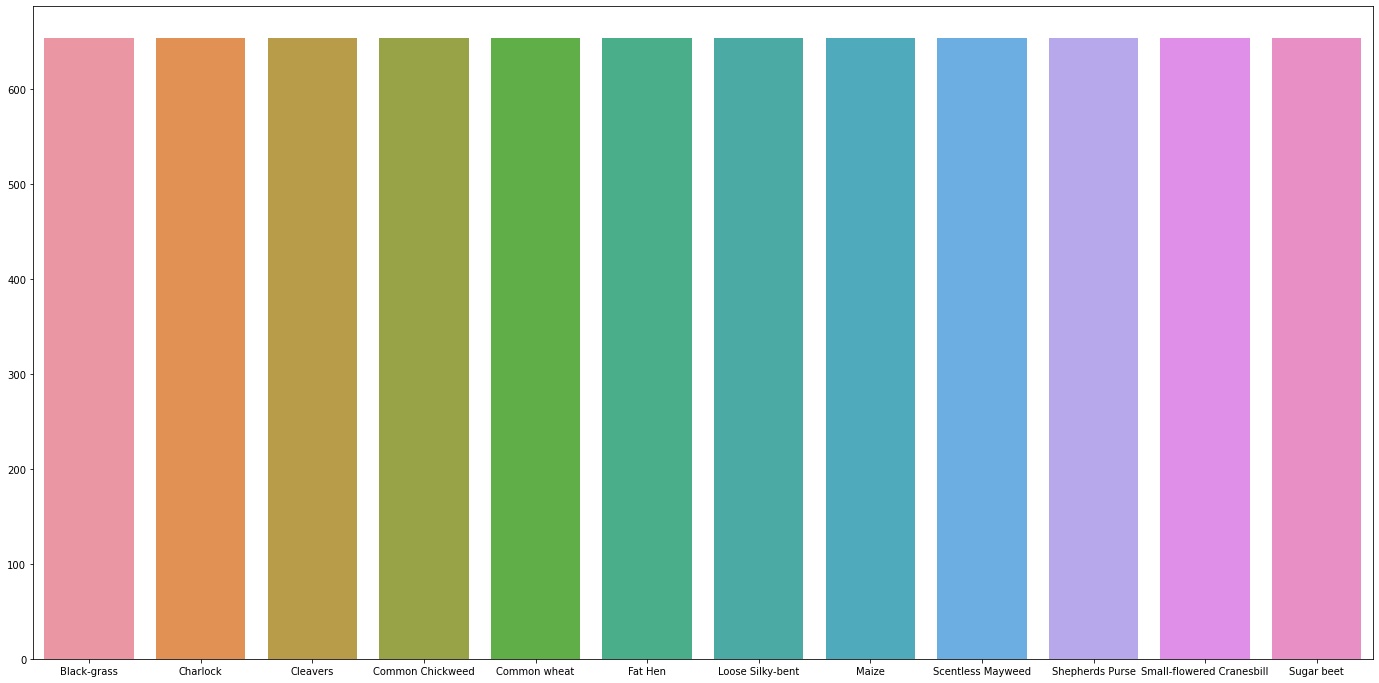

In [11]:
# We can confirm that the dataset was balanced

# Get names of all the categories 
categories = [category for category in sorted(os.listdir(save_dir))]

# Get the number of images in each cateogry
images_per_category = [len(os.listdir(os.path.join(save_dir, category))) for category in categories]

# Plot to see the distribution
plt.figure(figsize=(24,12))
sns.barplot(categories, images_per_category)

## Conclusion

> We can verify that the dataset is now balanced!

---

# **4. Training with Pre-Trained Models(with segmentation)**


We will train the following models to see which gives the best validation and test accuracies

* Inception v3
* VGG16
* ResNet50


## **1. InceptionV3**

In [12]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "inception_v3")

# Define callbacks
model_save_path = '/kaggle/working/model_inceptionv3.h5'
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model_inceptionv3.h5', monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


In [13]:
# Configure model for transfer learning
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:152]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_inception_v3 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])



87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/32
196/196 [==============================] - 184s 938ms/step - loss: 1.8942 - accuracy: 0.3806 - val_loss: 1.0950 - val_accuracy: 0.7058 - lr: 1.0000e-05
Epoch 2/32
196/196 [==============================] - 178s 906ms/step - loss: 0.8849 - accuracy: 0.7529 - val_loss: 0.5709 - val_accuracy: 0.8206 - lr: 1.0000e-05
Epoch 3/32
196/196 [==============================] - 177s 904ms/step - loss: 0.5325 - accuracy: 0.8469 - val_loss: 0.4109 - val_accuracy: 0.8605 - lr: 1.0000e-05
Epoch 4/32
196/196 [==============================] - 179s 911ms/step - loss: 0.3672 - accuracy: 0.8915 - val_loss: 0.3309 - val_accuracy: 0.8844 - lr: 1.0000e-05
Epoch 5/32
196/196 [==============================] - 179s 911ms/step - loss: 0.2984 - accuracy: 0.9122 - val_loss: 0.2681 - val_accuracy: 0.9048 - lr: 1.0000e-05
Epoch 6/32
196/196 [==============================] - 188s 959ms/step - loss: 0.2536 - accuracy: 0.9206 - val_loss: 0.26

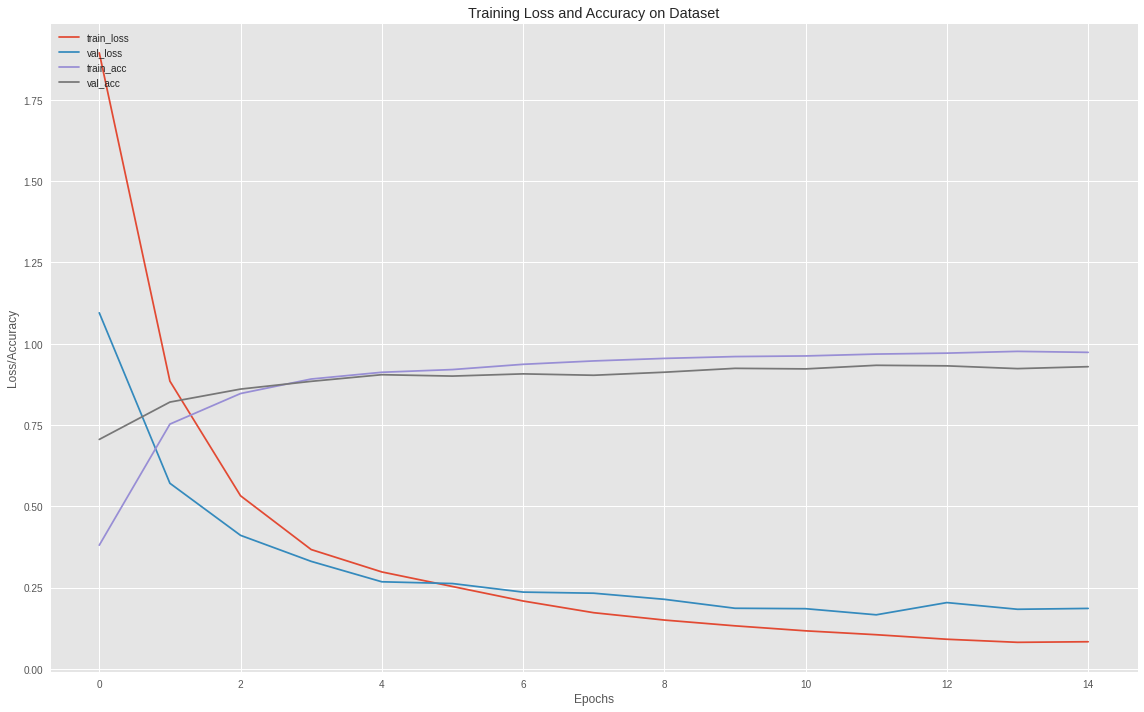

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.82      0.54      0.65        98
                 Charlock       0.99      1.00      0.99        98
                 Cleavers       1.00      0.98      0.99        98
         Common Chickweed       0.97      1.00      0.98        98
             Common wheat       0.94      0.94      0.94        98
                  Fat Hen       0.96      0.98      0.97        98
         Loose Silky-bent       0.66      0.89      0.76        98
                    Maize       0.99      0.99      0.99        98
        Scentless Mayweed       0.95      0.97      0.96        98
          Shepherds Purse       0.99      0.94      0.96        98
Small-flowered Cranesbill       1.00      1.00      1.00        98
               Sugar beet       1.00      0.98      0.99        98

                 accuracy                           0.93      1176
                macro avg       0.94  

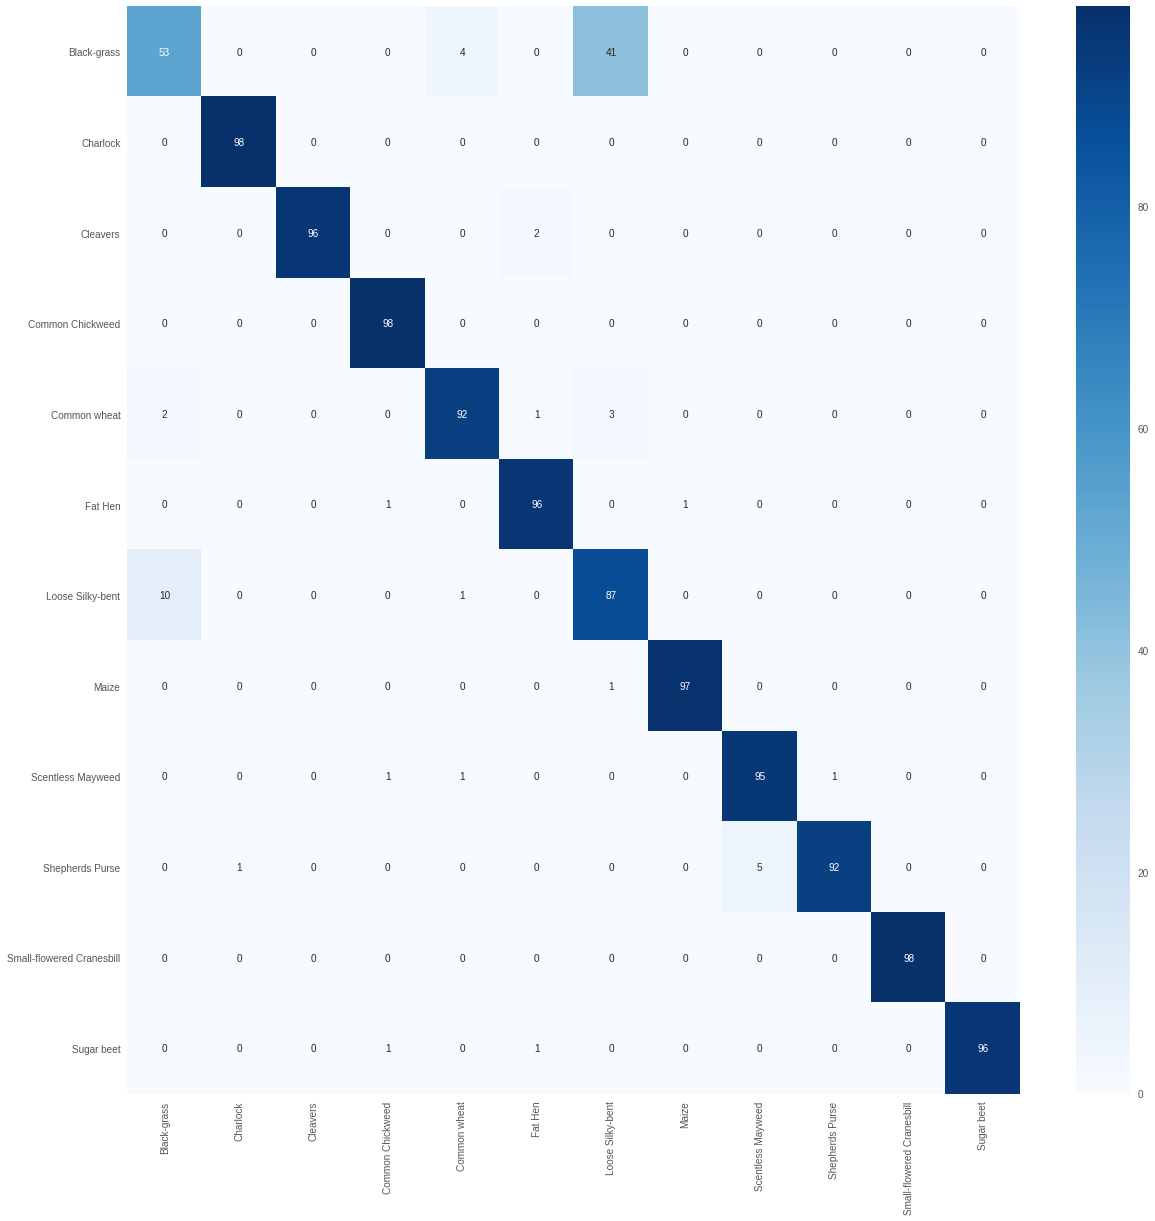

In [14]:
# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_inception_v3, model, val_generator)

## **2. VGG16**

In [15]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "vgg16")

# Define callbacks
model_save_path = '/kaggle/working/model_vgg16.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


In [16]:
# Configure model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:-11]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_vgg16 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])



58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/32
196/196 [==============================] - 107s 546ms/step - loss: 2.1112 - accuracy: 0.2944 - val_loss: 1.0761 - val_accuracy: 0.6658 - lr: 1.0000e-05
Epoch 2/32
196/196 [==============================] - 107s 546ms/step - loss: 1.0094 - accuracy: 0.6546 - val_loss: 0.5809 - val_accuracy: 0.7976 - lr: 1.0000e-05
Epoch 3/32
196/196 [==============================] - 107s 544ms/step - loss: 0.6170 - accuracy: 0.7933 - val_loss: 0.3963 - val_accuracy: 0.8461 - lr: 1.0000e-05
Epoch 4/32
196/196 [==============================] - 107s 545ms/step - loss: 0.4639 - accuracy: 0.8398 - val_loss: 0.4574 - val_accuracy: 0.8316 - lr: 1.0000e-05
Epoch 5/32
196/196 [==============================] - 105s 536ms/step - loss: 0.3517 - accuracy: 0.8803 - val_loss: 0.3684 - val_accuracy: 0.8554 - lr: 2.0000e-06
Epoch 6/32
196/196 [==============================] - 105s 536ms/step - loss: 0.3222 - accuracy: 0.8925 - val_loss: 0.29

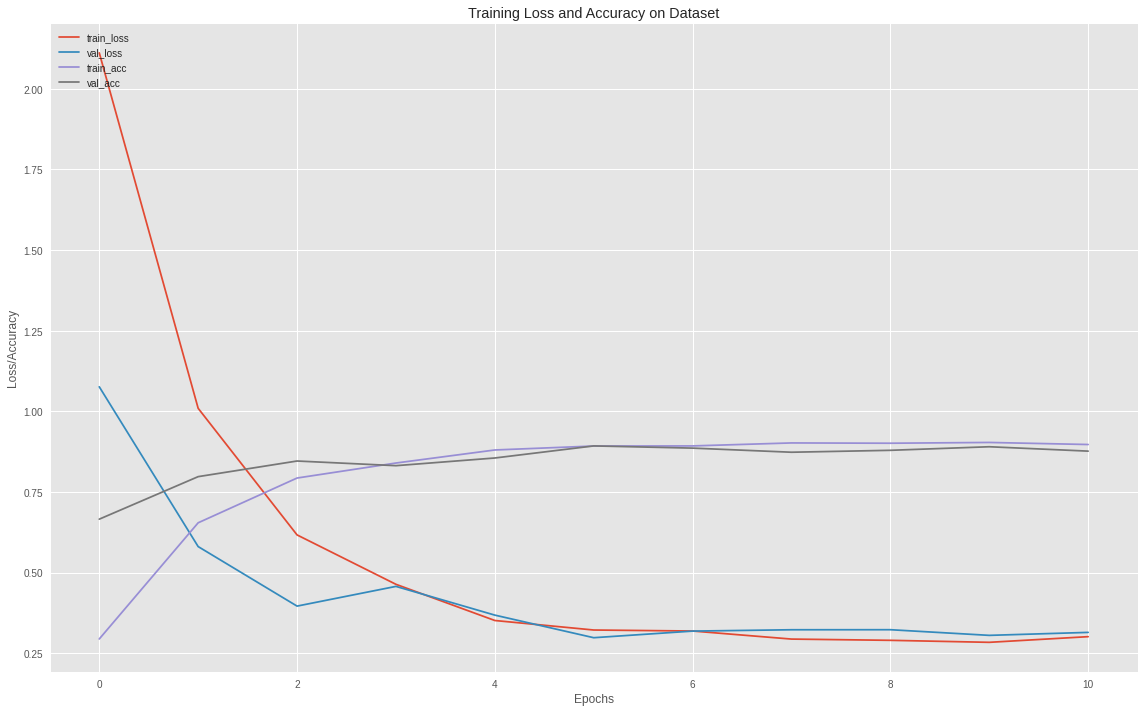

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.76      0.49      0.60        98
                 Charlock       0.98      0.99      0.98        98
                 Cleavers       0.99      0.92      0.95        98
         Common Chickweed       0.97      0.98      0.97        98
             Common wheat       0.88      0.96      0.92        98
                  Fat Hen       0.93      0.94      0.93        98
         Loose Silky-bent       0.60      0.80      0.68        98
                    Maize       1.00      0.94      0.97        98
        Scentless Mayweed       0.81      0.94      0.87        98
          Shepherds Purse       0.93      0.78      0.84        98
Small-flowered Cranesbill       0.95      0.99      0.97        98
               Sugar beet       0.95      0.95      0.95        98

                 accuracy                           0.89      1176
                macro avg       0.90  

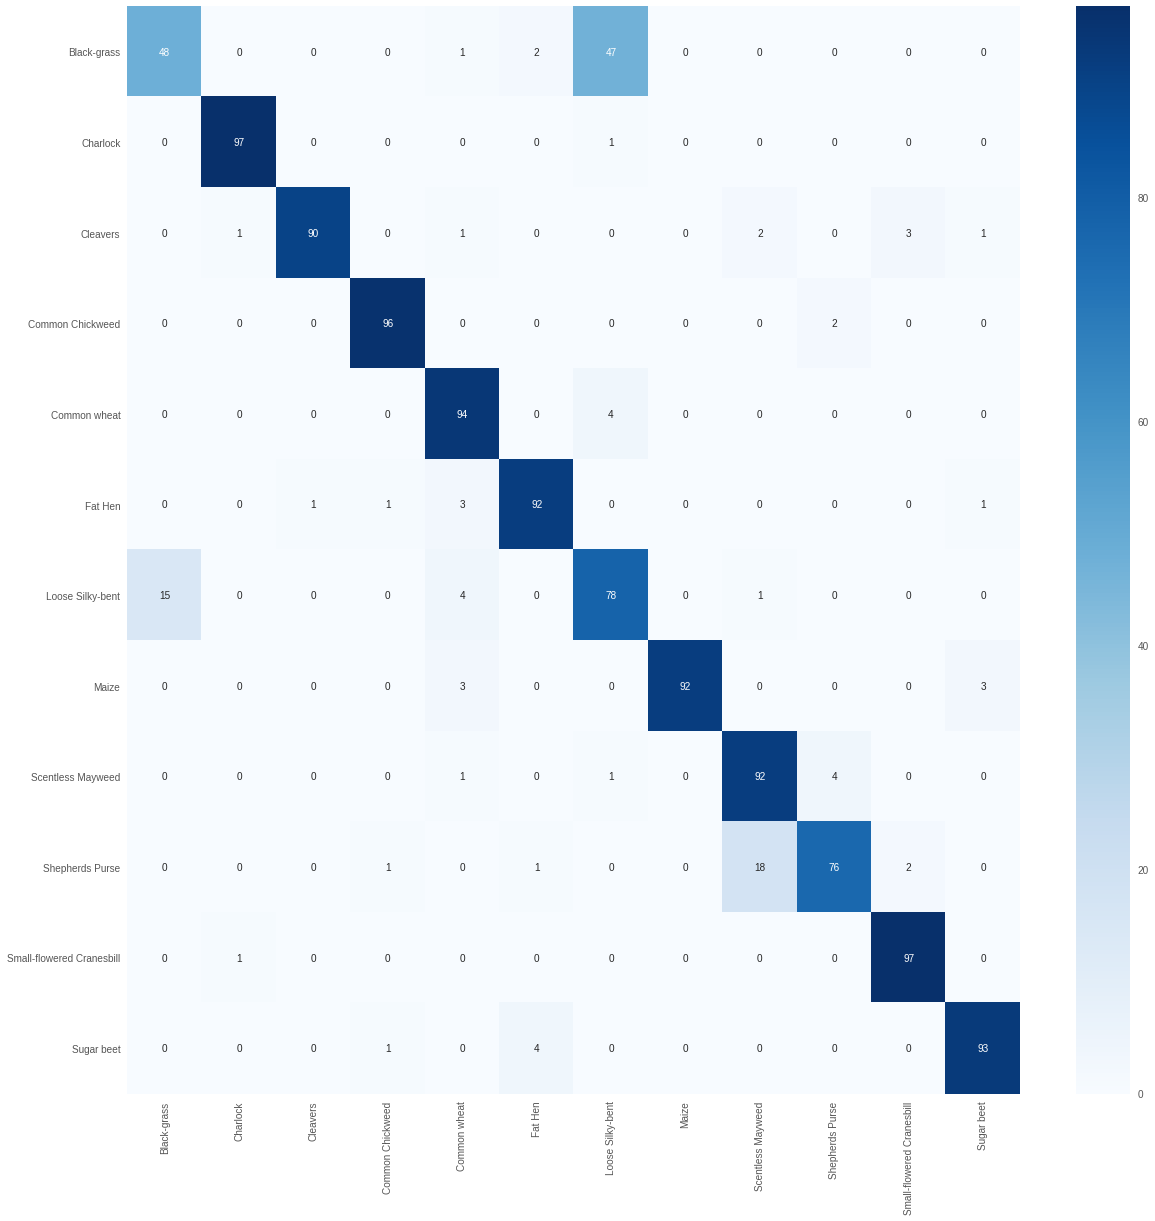

In [17]:
# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_vgg16, model, val_generator)

## **3. ResNet50**

In [18]:
# Load generators for the data using the DataLoader Class
train_generator, val_generator = dataloader.load_for_train(model = "resnet50")

# Define callbacks
model_save_path = '/kaggle/working/model_resent50.h5'
checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min', restore_best_weights=True)

Found 6672 images belonging to 12 classes.
Found 1176 images belonging to 12 classes.


In [19]:
# Configure model for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = base_model.output
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# Freeze the earlier layers
for layer in model.layers[:81]:
    layer.trainable = False
    
    
# Compile the model    
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



# Train the model
history_resent50 = model.fit_generator(train_generator,
                      steps_per_epoch = 196,
                      validation_data = val_generator,
                      validation_steps = 48,
                      epochs = 32,
                      verbose = 1,
                      callbacks = [reduce_lr, checkpoint, early_stop])



94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/32
196/196 [==============================] - 106s 540ms/step - loss: 1.8060 - accuracy: 0.4118 - val_loss: 0.8175 - val_accuracy: 0.7296 - lr: 1.0000e-05
Epoch 2/32
196/196 [==============================] - 108s 553ms/step - loss: 0.7412 - accuracy: 0.7642 - val_loss: 0.4337 - val_accuracy: 0.8410 - lr: 1.0000e-05
Epoch 3/32
196/196 [==============================] - 106s 540ms/step - loss: 0.4557 - accuracy: 0.8526 - val_loss: 0.3433 - val_accuracy: 0.8733 - lr: 1.0000e-05
Epoch 4/32
196/196 [==============================] - 109s 555ms/step - loss: 0.3239 - accuracy: 0.8967 - val_loss: 0.2851 - val_accuracy: 0.8886 - lr: 1.0000e-05
Epoch 5/32
196/196 [==============================] - 106s 540ms/step - loss: 0.2699 - accuracy: 0.9124 - val_loss: 0.2631 - val_accuracy: 0.8963 - lr: 1.0000e-05
Epoch 6/32
196/196 [==============================] - 105s 536ms/step - loss: 0.2200 - accuracy: 0.9282 - val_loss: 0.25

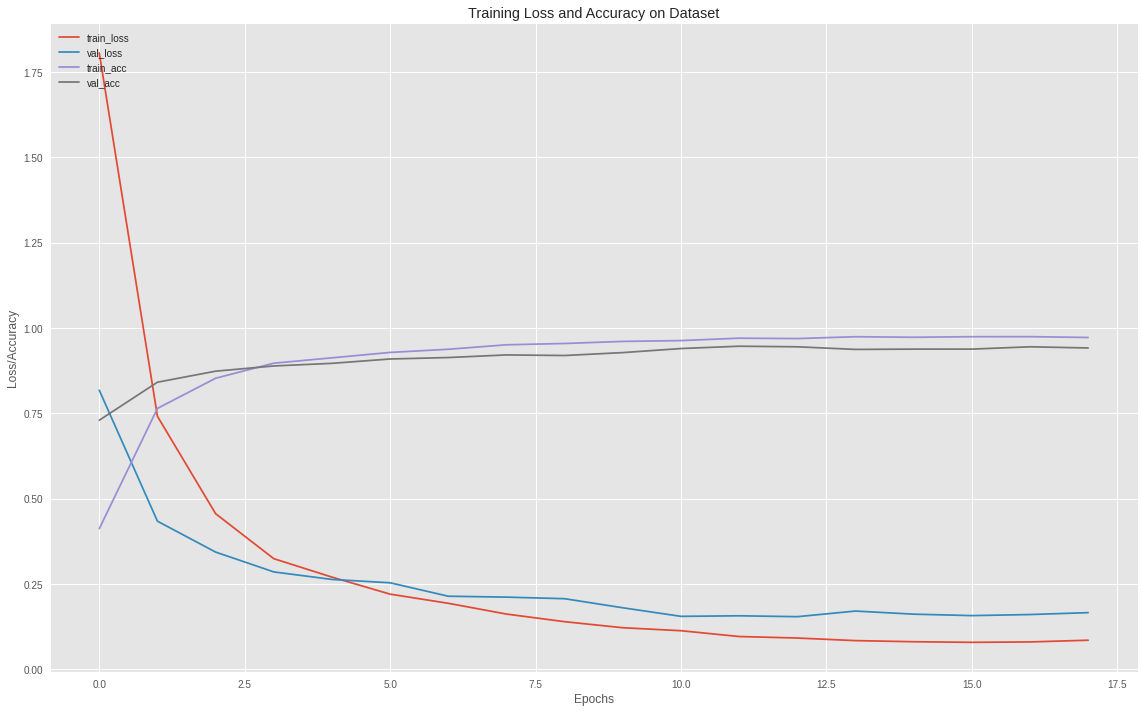

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.84      0.52      0.64        98
                 Charlock       0.99      0.99      0.99        98
                 Cleavers       1.00      0.96      0.98        98
         Common Chickweed       0.98      1.00      0.99        98
             Common wheat       0.98      0.99      0.98        98
                  Fat Hen       0.95      0.98      0.96        98
         Loose Silky-bent       0.66      0.91      0.76        98
                    Maize       1.00      0.99      0.99        98
        Scentless Mayweed       0.97      0.98      0.97        98
          Shepherds Purse       0.99      0.98      0.98        98
Small-flowered Cranesbill       0.99      1.00      0.99        98
               Sugar beet       0.99      0.97      0.98        98

                 accuracy                           0.94      1176
                macro avg       0.94  

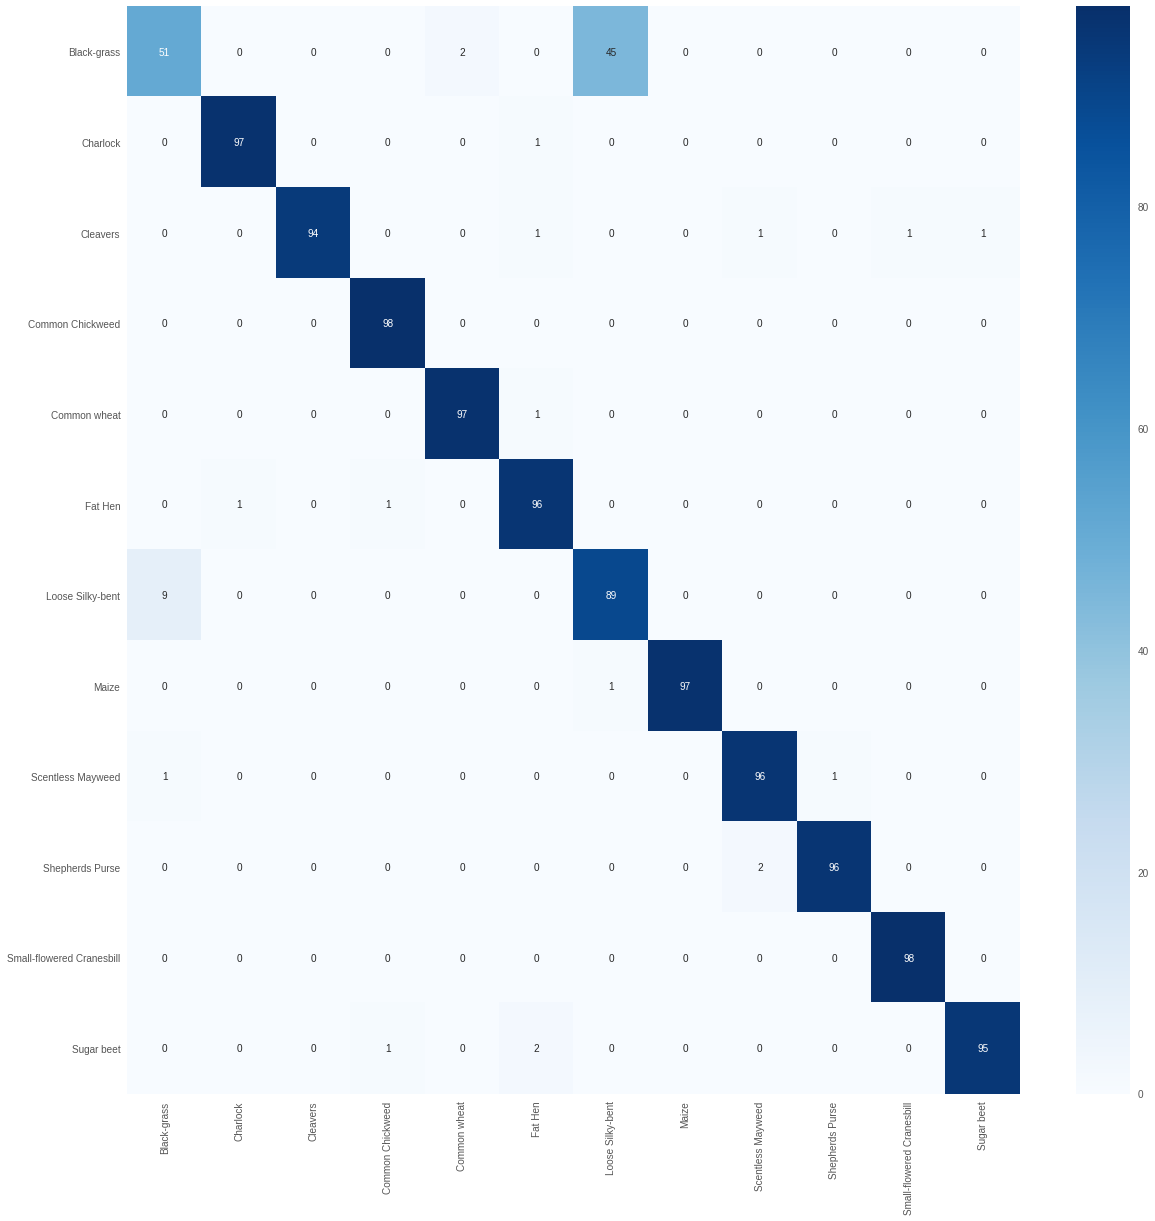

In [20]:
# Load the best model
model = load_model(model_save_path)
# Summarize the best model
utils.summarize_model(history_resent50, model, val_generator)

# **Conclusion**

___

* **ResNet50** architecture trained with **segmentation** of the images and with **data augmentation** gave the best accuracy of **94.2%**
* An important point to note is the misclassifications between Black-grass and Loose Silky-bent. 
* VGG gave lesser misclassifications among these two classes but with a lesser validation accuracy.
* Hence, VGG model showed lesser overfitting but accuracy was just 87.6% .
* Wthout segmentations the validation accuracy was around 91-92% for all the models, but the models got overfit.



___